In [1]:
#!/usr/bin/env python
# coding: utf-8

#import sciencep/lots
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 
import pickle 

from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import StandardScaler

from helpers.synthesis_plots import *

plt.style.use("science.mplstyle")

#plt.style.use('science')
dpi = 800

In [5]:
scatterplot_dir = "/global/ml4hep/spss/rrmastandrea/NF_results_SSS/"


n_seed = 1

num_bkg = 340000
num_sig = 20000

## Visualize the scatterplots 

First run ```run_scatterplot.py```

In [6]:
def load_in_data(num_signal_to_inject, process, synth_ids):

    all_results_bkg = {iid:{} for iid in synth_ids}
    all_results_sig = {iid:{} for iid in synth_ids}

    
    for iid in synth_ids:
        for seed_NN in range(n_seed):

            if iid != "fullsup":
                data = np.load(f"{scatterplot_dir}/nsig_inj{num_signal_to_inject}_seed1/{iid}_results_seedNN{seed_NN}_nsig{num_signal_to_inject}.npy")
            else:
                data = np.load(f"{scatterplot_dir}/nsig_inj{num_signal_to_inject}_seed1/full_sup_results_seedNN{seed_NN}.npy")

            print(data.shape)
            # currently standardizing each random seed independently. May want to revisit!
            if process == "StandardScale":
                data_stand = StandardScaler().fit_transform(data)

            elif process == "IsotonicReg":
                true_labels = np.concatenate((np.zeros((num_bkg,)), np.ones((num_sig,))))
                data_stand = IsotonicRegression().fit_transform(data, true_labels).reshape(-1, 1)
            elif process == "None":
                data_stand = data
                
            

            data_bkg = data_stand[:num_bkg]
            data_sig = data_stand[num_bkg:]

            all_results_bkg[iid][seed_NN] = data_bkg
            all_results_sig[iid][seed_NN] = data_sig
            
            
    return all_results_bkg, all_results_sig


In [21]:
num_signal_to_inject = 2000


process = "None"

synth_ids = ["feta", "cathode", "curtains", "salad"]#, "combined"]
all_results_bkg, all_results_sig = load_in_data(num_signal_to_inject, process, synth_ids)

(360000, 1)
(360000, 1)
(360000, 1)
(360000, 1)


## Plot samples against each other for all random seeds

In [22]:
def concatenate_scatterplot_data(all_results_bkg, all_results_sig, synth_ids):
    
    concatenated_results_bkg = {iid:0 for iid in synth_ids}
    concatenated_results_sig = {iid:0 for iid in synth_ids}


    for iid in synth_ids:
        loc_holder_bkg = np.empty((0, 1))
        loc_holder_sig = np.empty((0, 1))

        for seed_NN in range(n_seed):
            loc_holder_bkg = np.concatenate((loc_holder_bkg, all_results_bkg[iid][seed_NN]), axis = 0)
            loc_holder_sig = np.concatenate((loc_holder_sig, all_results_sig[iid][seed_NN]), axis = 0)

        concatenated_results_bkg[iid] = loc_holder_bkg
        concatenated_results_sig[iid] = loc_holder_sig
        
    return concatenated_results_bkg, concatenated_results_sig


In [23]:
concatenated_results_bkg, concatenated_results_sig = concatenate_scatterplot_data(all_results_bkg, all_results_sig, synth_ids)

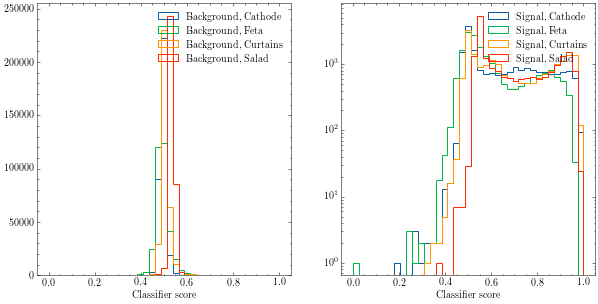

In [24]:
# Make sure that the first half is background, second half is signal

bins = np.linspace(0, 1, 40)
fig, ax = plt.subplots(1, 2, figsize = (10, 5))


#ax[0].hist(concatenated_results_bkg["fullsup"], bins = bins, histtype = "step", label = "Background, Full. Sup.")
#ax[1].hist(concatenated_results_sig["fullsup"], bins = bins, histtype = "step", label = "Signal, Full. Sup.")


ax[0].hist(concatenated_results_bkg["cathode"], bins = bins, histtype = "step", label = "Background, Cathode")
ax[1].hist(concatenated_results_sig["cathode"], bins = bins, histtype = "step", label = "Signal, Cathode")

ax[0].hist(concatenated_results_bkg["feta"], bins = bins, histtype = "step", label = "Background, Feta")
ax[1].hist(concatenated_results_sig["feta"], bins = bins, histtype = "step", label = "Signal, Feta")


ax[0].hist(concatenated_results_bkg["curtains"], bins = bins, histtype = "step", label = "Background, Curtains")
ax[1].hist(concatenated_results_sig["curtains"], bins = bins, histtype = "step", label = "Signal, Curtains")


ax[0].hist(concatenated_results_bkg["salad"], bins = bins, histtype = "step", label = "Background, Salad")
ax[1].hist(concatenated_results_sig["salad"], bins = bins, histtype = "step", label = "Signal, Salad")

ax[1].set_yscale("log")


ax[0].set_xlabel("Classifier score")
ax[1].set_xlabel("Classifier score")

ax[0].legend()
ax[1].legend()


plt.show()


In [25]:
import matplotlib.colors as colors

def make_plot(bkg_x, bkg_y, sig_x, sig_y, label_x, label_y, num_bins = 100, plot_lims = 5, vmax = 5e3):
    
    # plot params
    b = np.linspace(-plot_lims, plot_lims, num_bins)
    cmap = "rainbow"
    fontsize = 30
    small_font = 20


    fig, ax = plt.subplots(1, 2, figsize = (16, 8))

    img_bkg = ax[0].hist2d(bkg_x.flatten(), bkg_y.flatten(), bins = b, norm=colors.LogNorm(vmin=1e0, vmax=vmax), cmap = cmap, density = False)
    ax[0].plot([-plot_lims, plot_lims], [-plot_lims, plot_lims], color = "black")
    ax[0].set_xlabel(label_x, fontsize = fontsize)
    ax[0].set_ylabel(label_y, fontsize = fontsize)
    ax[0].set_title("Background", fontsize = fontsize)
    ax[0].set_aspect(1)
    ax[0].text(-3, 4, f"$n_\\mathrm{{sig}}$ = {num_signal_to_inject}", fontsize = fontsize)
    ax[0].tick_params(axis='both', which='major', labelsize=small_font)
    

    img_sig = ax[1].hist2d(sig_x.flatten(), sig_y.flatten(), bins = b, norm=colors.LogNorm(vmin=1e0, vmax=vmax), cmap = cmap, density = False)
    ax[1].plot([-plot_lims, plot_lims], [-plot_lims, plot_lims], color = "black")
    ax[1].set_xlabel(label_x, fontsize = fontsize)
    ax[1].set_ylabel(label_y, fontsize = fontsize)
    ax[1].set_title("Signal", fontsize = fontsize)
    ax[1].set_aspect(1)
    ax[1].text(-3, 4, f"$n_\\mathrm{{sig}}$ = {num_signal_to_inject}", fontsize = fontsize)
    ax[1].tick_params(axis='both', which='major', labelsize=small_font)
    
    cb_ax = fig.add_axes([.92,.2,.02,.6])
    cbar = fig.colorbar(img_sig[3],orientation='vertical',cax=cb_ax)


    cbar.ax.tick_params(labelsize=small_font, rotation = 270) 
    cbar.set_label("Counts", fontsize = small_font, rotation = 270, labelpad = 20)

    plt.show()
    return fig


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


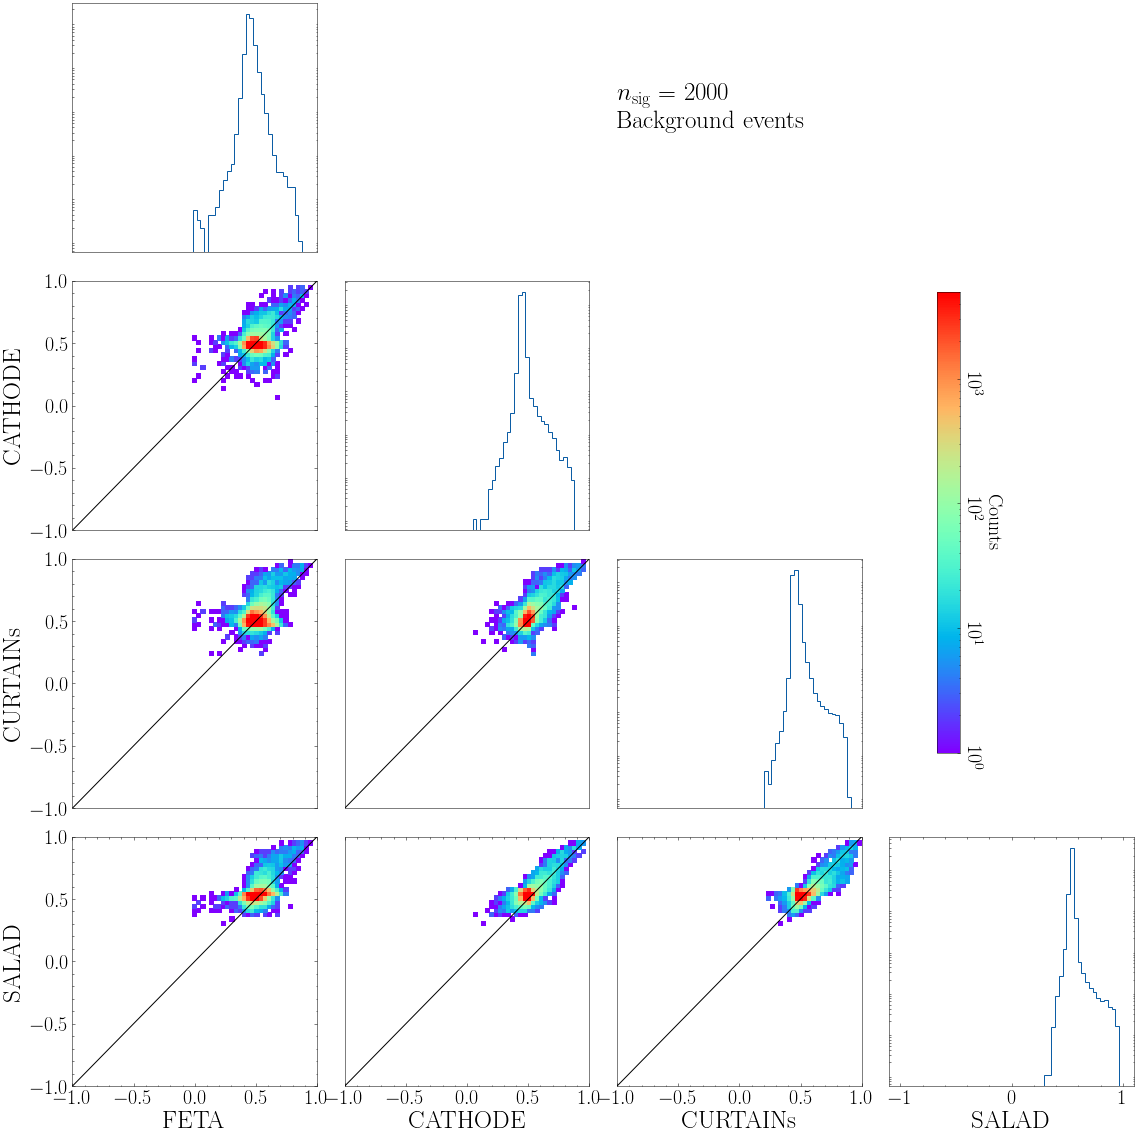

In [28]:
dim = len(synth_ids)

#params for all plots
num_bins = 60
lower_plot_lim, upper_plot_lim = -1, 1
vmax = 5e3
b = np.linspace(lower_plot_lim, upper_plot_lim, num_bins)
cmap = "rainbow"
fontsize = 25
small_font = 20


nice_labels = ["FETA", "CATHODE", "CURTAINs", "SALAD"]


fig, ax = plt.subplots(dim, dim, figsize = (4*dim, 4*dim))

for dim_x in range(dim):
    for dim_y in range(dim):
        
        
        if dim_x < dim_y: # plot the 2d hist
            img_bkg = ax[dim_y, dim_x].hist2d(concatenated_results_bkg[synth_ids[dim_x]].flatten(), 
                                          concatenated_results_bkg[synth_ids[dim_y]].flatten(), 
                                          bins = b, norm=colors.LogNorm(vmin=1e0, vmax=vmax), cmap = cmap, 
                                          density = False)
            ax[dim_y, dim_x].plot([lower_plot_lim, upper_plot_lim], [lower_plot_lim, upper_plot_lim], color = "black")
            
        
        elif dim_x == dim_y: # plot the 1d hist
            ax[dim_x, dim_x].hist(concatenated_results_bkg[synth_ids[dim_x]].flatten(), bins = b, histtype = "step")
            ax[dim_x, dim_x].set_yscale("log")
            
        else:
            ax[dim_y, dim_x].set_axis_off()
            
        # axis labels
        if dim_y == dim - 1:
            ax[dim_y, dim_x].set_xlabel(nice_labels[dim_x], fontsize = fontsize)
            ax[dim_y, dim_x].tick_params(axis='x', which='major', labelsize=small_font)
        else:
            ax[dim_y, dim_x].set_xticks([])
        if (dim_x == 0) and (dim_y != 0):
            ax[dim_y, dim_x].set_ylabel(nice_labels[dim_y], fontsize = fontsize)
            ax[dim_y, dim_x].tick_params(axis='y', which='major', labelsize=small_font)
        else:
            ax[dim_y, dim_x].set_yticks([])
            
# label
ax[0, 2].text(0, .5, f"$n_\\mathrm{{sig}}$ = {num_signal_to_inject}\nBackground events", fontsize = fontsize)

# colorbar (they all have the same one)
cb_ax = fig.add_axes([.82,.34,.02,.4])
cbar = fig.colorbar(img_bkg[3],orientation='vertical',cax=cb_ax)

cbar.ax.tick_params(labelsize=small_font, rotation = 270) 
cbar.set_label("Counts", fontsize = small_font, rotation = 270, labelpad = 20)

        

            

plt.tight_layout()
fig.show()


fig.savefig(f"paper_plots/corner_bkg_{num_signal_to_inject}.pdf", dpi = dpi)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


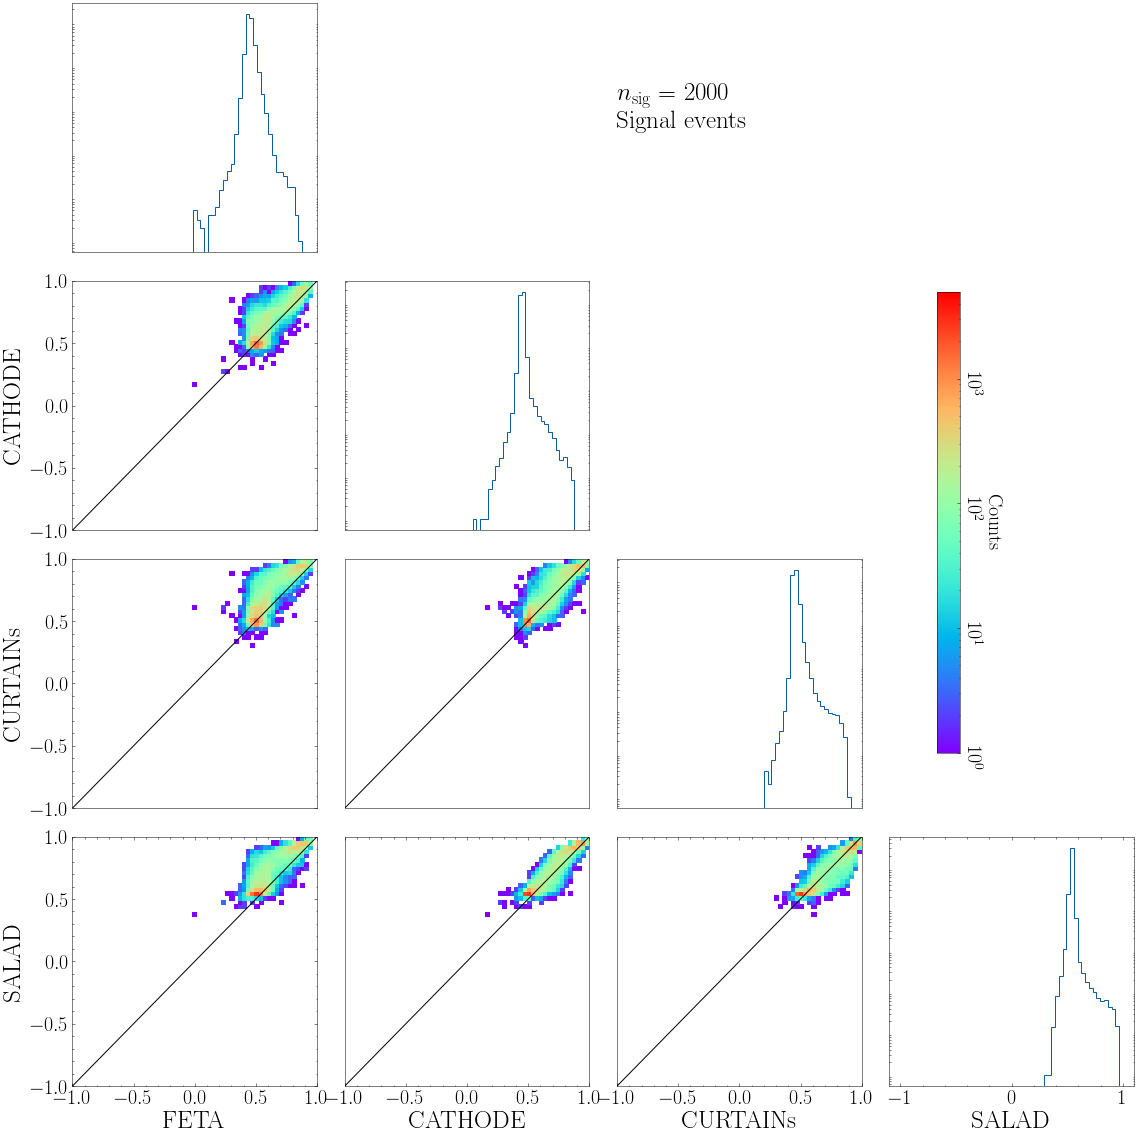

In [29]:

#params for all plots
num_bins = 60
lower_plot_lim, upper_plot_lim = -1, 1
vmax = 5e3
b = np.linspace(lower_plot_lim, upper_plot_lim, num_bins)
cmap = "rainbow"
fontsize = 25
small_font = 20





fig, ax = plt.subplots(dim, dim, figsize = (4*dim, 4*dim))



for dim_x in range(dim):
    for dim_y in range(dim):
        
        if dim_x < dim_y: # plot the 2d hist
            img_sig = ax[dim_y, dim_x].hist2d(concatenated_results_sig[synth_ids[dim_x]].flatten(), 
                                          concatenated_results_sig[synth_ids[dim_y]].flatten(), 
                                          bins = b, norm=colors.LogNorm(vmin=1e0, vmax=vmax), cmap = cmap, 
                                          density = False)
            ax[dim_y, dim_x].plot(b, b, color = "black")
            
        
        elif dim_x == dim_y: # plot the 1d hist
            ax[dim_x, dim_x].hist(concatenated_results_bkg[synth_ids[dim_x]].flatten(), bins = b, histtype = "step")
            ax[dim_x, dim_x].set_yscale("log")
            
        else:
            ax[dim_y, dim_x].set_axis_off()
            
        # axis labels
        if dim_y == dim - 1:
            ax[dim_y, dim_x].set_xlabel(nice_labels[dim_x], fontsize = fontsize)
            ax[dim_y, dim_x].tick_params(axis='x', which='major', labelsize=small_font)
        else:
            ax[dim_y, dim_x].set_xticks([])
        if (dim_x == 0) and (dim_y != 0):
            ax[dim_y, dim_x].set_ylabel(nice_labels[dim_y], fontsize = fontsize)
            ax[dim_y, dim_x].tick_params(axis='y', which='major', labelsize=small_font)
        else:
            ax[dim_y, dim_x].set_yticks([])
            
# label
ax[0, 2].text(0, .5, f"$n_\\mathrm{{sig}}$ = {num_signal_to_inject}\nSignal events", fontsize = fontsize)

# colorbar (they all have the same one)
cb_ax = fig.add_axes([.82,.34,.02,.4])
cbar = fig.colorbar(img_sig[3],orientation='vertical',cax=cb_ax)

cbar.ax.tick_params(labelsize=small_font, rotation = 270) 
cbar.set_label("Counts", fontsize = small_font, rotation = 270, labelpad = 20)



            

plt.tight_layout()
fig.show()

fig.savefig(f"paper_plots/corner_sig_{num_signal_to_inject}.pdf", dpi = dpi)


## Plot one method's samples against each other for different random seeds

In [ ]:

seed_1 = 1
seed_2 = 0



fig = make_plot(all_results_bkg["feta"][seed_1], all_results_bkg["feta"][seed_2], 
          all_results_sig["feta"][seed_1], all_results_sig["feta"][seed_2], 
          f"FETA seed {seed_1}", f"FETA seed {seed_2}")
fig.savefig(f"paper_plots/feta_v_feta_{num_signal_to_inject}.pdf", dpi = dpi)


fig = make_plot(all_results_bkg["cathode"][seed_1], all_results_bkg["cathode"][seed_2], 
          all_results_sig["cathode"][seed_1], all_results_sig["cathode"][seed_2], 
          f"CATHODE seed {seed_1}", f"CATHODE seed {seed_2}")
fig.savefig(f"paper_plots/cathode_v_cathode_{num_signal_to_inject}.pdf", dpi = dpi)


fig = make_plot(all_results_bkg["curtains"][seed_1], all_results_bkg["curtains"][seed_2], 
          all_results_sig["curtains"][seed_1], all_results_sig["curtains"][seed_2], 
          f"CURTAINs seed {seed_1}", f"CURTAINs seed {seed_2}")
fig.savefig(f"paper_plots/curtains_v_curtains_{num_signal_to_inject}.pdf", dpi = dpi)

fig = make_plot(all_results_bkg["salad"][seed_1], all_results_bkg["salad"][seed_2], 
          all_results_sig["salad"][seed_1], all_results_sig["salad"][seed_2], 
          f"SALAD seed {seed_1}", f"SALAD seed {seed_2}")
fig.savefig(f"paper_plots/salad_v_salad_{num_signal_to_inject}.pdf", dpi = dpi)





fig = make_plot(all_results_bkg["fullsup"][seed_1], all_results_bkg["fullsup"][seed_2], 
          all_results_sig["fullsup"][seed_1], all_results_sig["fullsup"][seed_2], 
          f"Full. Sup. seed {seed_1}", f"Full. Sup. seed {seed_2}")
fig.savefig(f"paper_plots/fullsup_v_fullsup{num_signal_to_inject}.pdf", dpi = dpi)





## Get fraction of shared events

In [ ]:
# Load in the data


num_signals_to_inject = [0, 300, 500, 750, 1000, 1200, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

synth_ids = ["feta", "cathode", "curtains", "salad"]


summary_dict_bkg, summary_dict_sig = {}, {}


# load in and concatentate data
for nn in num_signals_to_inject:

    all_results_bkg, all_results_sig = load_in_data(nn, process, synth_ids)    
    concatenated_results_bkg, concatenated_results_sig = concatenate_scatterplot_data(all_results_bkg, all_results_sig, synth_ids)

    summary_dict_bkg[nn] = concatenated_results_bkg
    summary_dict_sig[nn] = concatenated_results_sig
    

In [ ]:
def get_highest_percentile(scores, num_ids_to_take):
    
    # array to keep track of the id
    ids = np.arange(len(scores))
    
    # sort the ids by the scores
    sorted_ids = [x for _,x in sorted(zip(scores,ids))]
    sorted_scores = [x for x,_ in sorted(zip(scores,ids))]

    # return the highest ids
    return(sorted_ids[-num_ids_to_take:])



In [ ]:
random_1 = np.random.uniform(size = (concatenated_results_bkg["feta"].shape[0]))
random_2 = np.random.uniform(size = (concatenated_results_bkg["feta"].shape[0]))

all_overlap_bkg = {nn:[] for nn in num_signals_to_inject}
all_overlap_sig = {nn:[] for nn in num_signals_to_inject}

pairs_overlap_bkg = {}
pairs_overlap_sig = {}

for i, id_1 in enumerate(synth_ids):
    for j, id_2 in enumerate(synth_ids[i+1:]):
        pair_id = id_1 + "_" + id_2
        pairs_overlap_bkg[pair_id] = {nn:[] for nn in num_signals_to_inject}
        pairs_overlap_sig[pair_id] = {nn:[] for nn in num_signals_to_inject}     

random_overlap = []

percentiles = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for p in percentiles:
    
    print(f"Evaluating percentile {p}...")
    
    # random
    num_ids_to_take_rand = int(p*summary_dict_bkg[nn]["feta"].shape[0])
    #print(f"Random: Taking the top {num_ids_to_take_rand} scores ({p} percentile)")

    random_1_ids = get_highest_percentile(random_1.flatten(), num_ids_to_take_rand)
    random_2_ids = get_highest_percentile(random_2.flatten(), num_ids_to_take_rand)

    random_ov = list(set(random_1_ids) & set(random_2_ids))
    random_overlap.append(float(len(random_ov))/num_ids_to_take_rand)

    for nn in num_signals_to_inject:
          
        print(f"Evaluating num. injected signal events {nn}...")

        # background
        num_ids_to_take_bkg = int(p*summary_dict_bkg[nn]["feta"].shape[0])
        #print(f"Background: Taking the top {num_ids_to_take_bkg} scores ({p} percentile)")
        
        local_ids_bkg = {}
        
        for iid in synth_ids:
            local_ids_bkg[iid] = get_highest_percentile(summary_dict_bkg[nn][iid].flatten(), num_ids_to_take_bkg)

        for i, id_1 in enumerate(synth_ids):
            for j, id_2 in enumerate(synth_ids[i+1:]):
                pair_id = id_1 + "_" + id_2
                
                loc_overlap_bkg = list(set(local_ids_bkg[id_1]) & set(local_ids_bkg[id_2]))
                pairs_overlap_bkg[pair_id][nn].append(float(len(loc_overlap_bkg))/num_ids_to_take_bkg)
                            
        grand_uni_bkg = list(set(local_ids_bkg["feta"]) & set(local_ids_bkg["cathode"]) & set(local_ids_bkg["curtains"]) & set(local_ids_bkg["salad"]))

        all_overlap_bkg[nn].append(float(len(grand_uni_bkg))/num_ids_to_take_bkg)
        

        # all
        num_ids_to_take_sig = int(p*summary_dict_sig[nn]["feta"].shape[0])
        
        local_ids_sig = {}
        
        for iid in synth_ids:
            local_ids_sig[iid] = get_highest_percentile(summary_dict_sig[nn][iid].flatten(), num_ids_to_take_sig)

        for i, id_1 in enumerate(synth_ids):
            for j, id_2 in enumerate(synth_ids[i+1:]):
                pair_id = id_1 + "_" + id_2
                
                loc_overlap_sig = list(set(local_ids_sig[id_1]) & set(local_ids_sig[id_2]))
                pairs_overlap_sig[pair_id][nn].append(float(len(loc_overlap_sig))/num_ids_to_take_sig)
                            
        grand_uni_sig = list(set(local_ids_sig["feta"]) & set(local_ids_sig["cathode"]) & set(local_ids_sig["curtains"]) & set(local_ids_sig["salad"]))

        all_overlap_sig[nn].append(float(len(grand_uni_sig))/num_ids_to_take_sig)
        
    print()

    



In [ ]:
pickle.dump( all_overlap_bkg, open( "all_overlap_bkg.p", "wb" ) )
pickle.dump( all_overlap_sig, open( "all_overlap_sig.p", "wb" ) )
pickle.dump( random_overlap, open( "random_overlap.p", "wb" ) )

pickle.dump( pairs_overlap_bkg, open( "pairs_overlap_bkg.p", "wb" ) )
pickle.dump( pairs_overlap_sig, open( "pairs_overlap_sig.p", "wb" ) )





In [ ]:

all_overlap_bkg = pickle.load( open( "all_overlap_bkg.p", "rb" ) )
all_overlap_sig = pickle.load(  open( "all_overlap_sig.p", "rb" ) )
random_overlap = pickle.load(  open( "random_overlap.p", "rb" ) )


pairs_overlap_bkg = pickle.load(  open( "pairs_overlap_bkg.p", "rb" ) )
pairs_overlap_sig = pickle.load(  open( "pairs_overlap_sig.p", "rb" ) )



## For each signal injection, plot the overlap as a function of the score percentile

In [ ]:
percentiles = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fontsize = 30
small_font = 16

colors = ["orange", "red", "pink", "magenta", "purple", "blue"]

l = 3

num_to_plot = 2000


fig, ax = plt.subplots(2, 1, figsize = (12, 12))

ax[0].plot(percentiles, random_overlap, label = "Random", linewidth = l+2, color = "black")
ax[1].plot(percentiles, random_overlap, label = "Random", linewidth = l+2, color = "black")


k = 0
for i, id_1 in enumerate(synth_ids):
    for j, id_2 in enumerate(synth_ids[i+1:]):
        pair_id = id_1 + "_" + id_2
        
        plot_label = id_1 + " " + id_2

     

        ax[0].plot(percentiles, pairs_overlap_bkg[pair_id][num_to_plot], label = f"{plot_label}", linewidth = l, color = colors[k])
        ax[1].plot(percentiles, pairs_overlap_sig[pair_id][num_to_plot], label = f"{plot_label}", linewidth = l, color = colors[k])
        
        k += 1
        


ax[0].plot(percentiles, all_overlap_bkg[num_to_plot], label = "All methods", linewidth = l, color = "brown")
ax[1].plot(percentiles, all_overlap_sig[num_to_plot], label = "All methods", linewidth = l, color = "brown")



ax[0].legend(fontsize = small_font, bbox_to_anchor=(1.3, .2))
ax[0].set_xlabel("Score percentile (top)", fontsize = fontsize)
ax[0].set_ylabel("Fraction of shared events", fontsize = fontsize)
ax[0].set_xticks(ticks=[0, 0.25, 0.5, .75, 1])
ax[0].tick_params(axis='both', which='major', labelsize=small_font)
ax[0].text(.1, 0.8, f"$n_\\mathrm{{sig}}$ = {num_to_plot}\nBackground", fontsize = fontsize)



ax[1].set_xlabel("Score percentile (top)", fontsize = fontsize)
ax[1].set_ylabel("Fraction of shared events", fontsize = fontsize)
ax[1].set_xticks(ticks=[0, 0.25, 0.5, .75, 1])
ax[1].tick_params(axis='both', which='major', labelsize=small_font)
ax[1].text(.1, 0.8, f"$n_\\mathrm{{sig}}$ = {num_to_plot}\nSignal", fontsize = fontsize)





plt.show()

fig.savefig(f"paper_plots/unification_{num_to_plot}.pdf", dpi = dpi)


## For each score pecentile, plot the overlap as a function of the signal injection

In [ ]:
percentiles = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fontsize = 30
small_font = 16

l = 3


target_percentile = .2
target_percentile_index = percentiles.index(target_percentile)






loc_overlaps_bkg = {}
loc_overlaps_sig = {}

for i, id_1 in enumerate(synth_ids):
    for j, id_2 in enumerate(synth_ids[i+1:]):
        pair_id = id_1 + "_" + id_2
        loc_overlaps_bkg[pair_id] = []
        loc_overlaps_sig[pair_id] = []
        


loc_all_overlap_bkg = []
loc_all_overlap_sig = []
    
    
for nn in num_signals_to_inject:
    
    for i, id_1 in enumerate(synth_ids):
        for j, id_2 in enumerate(synth_ids[i+1:]):
            pair_id = id_1 + "_" + id_2
            
            
            loc_overlaps_bkg[pair_id].append(pairs_overlap_bkg[pair_id][nn][target_percentile_index])
            loc_overlaps_sig[pair_id].append(pairs_overlap_sig[pair_id][nn][target_percentile_index])

    
    loc_all_overlap_bkg.append(all_overlap_bkg[nn][target_percentile_index])
    loc_all_overlap_sig.append(all_overlap_sig[nn][target_percentile_index])

fig, ax = plt.subplots(2, 1, figsize = (12, 12))

k = 0
for i, id_1 in enumerate(synth_ids):
    for j, id_2 in enumerate(synth_ids[i+1:]):
        pair_id = id_1 + "_" + id_2
        plot_label = id_1 + " " + id_2


        ax[0].plot(num_signals_to_inject, loc_overlaps_bkg[pair_id], label = f"{plot_label}", linewidth = l, color = colors[k])
        ax[1].plot(num_signals_to_inject, loc_overlaps_sig[pair_id], label = f"{plot_label}", linewidth = l, color = colors[k], linestyle = "dashed")
        
        k += 1


ax[0].plot(num_signals_to_inject, loc_all_overlap_bkg, label = "All methods", linewidth = l, color = "brown")
ax[1].plot(num_signals_to_inject, loc_all_overlap_sig,  label = "All methods", linewidth = l, color = "brown", linestyle = "dashed")



ax[0].legend(fontsize = small_font, bbox_to_anchor=(1.3, .2))
ax[0].set_ylim(-.2, 1.2)
ax[0].set_xlabel("Num. injected signal events", fontsize = fontsize)
ax[0].set_ylabel("Fraction of shared events", fontsize = fontsize)
ax[0].set_xticks(ticks=num_signals_to_inject)
ax[0].tick_params(axis='both', which='major', labelsize=small_font)
ax[0].text(1.1, 0.9, f"Percentile = {target_percentile}\nBackground", fontsize = fontsize)


ax[1].set_ylim(-.2, 1.2)
ax[1].set_xlabel("Num. injected signal events", fontsize = fontsize)
ax[1].set_ylabel("Fraction of shared events", fontsize = fontsize)
ax[1].set_xticks(ticks=num_signals_to_inject)
ax[1].tick_params(axis='both', which='major', labelsize=small_font)
ax[1].text(1.1, 0.9, f"Percentile = {target_percentile}\nSignal", fontsize = fontsize)





plt.show()

fig.savefig(f"paper_plots/unification_percentile_{num_to_plot}.pdf", dpi = dpi)
